In [ ]:
!nvidia-smi

Wed Oct 12 04:51:00 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import pandas as pd
import numpy as np
import os
import cv2
import gc
import re
import copy
import itertools
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import pyplot
from tqdm import tqdm
from tqdm.notebook import tqdm
from datetime import datetime
import json,itertools
from typing import Optional
from glob import glob
import warnings
from IPython import display as ipd
warnings.filterwarnings("ignore")
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib as mpl
from matplotlib.patches import Rectangle
import seaborn as sns
import random
from joblib import Parallel, delayed

# 시드값 고정

In [ ]:
import torch
import random
import numpy as np
import os

# 시드값 고정
seed = 42
os.environ["PYTHONHASHSEED"] = str(seed)
random.seed(seed)                          # 파이썬 난수 
np.random.seed(seed)                       # 넘파이 난수
torch.manual_seed(seed)                    # 파이토치 난수 CPU 사용시
torch.cuda.manual_seed(seed)               # 파이토치 난수 GPU 사용시
torch.cuda.manual_seed_all(seed)           # 파이토치 난수 멀티 GPU 사용시
torch.backends.cudnn.deterministic = True  # 확정적 연산 사용
torch.backends.cudnn.benchmark = False     # 벤치마크 기능 해제
torch.backends.cudnn.enalbed = False       # cudnn 사용 해제

# 구글 드라이브 연동

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import glob

path = '/content/drive/MyDrive/data/plant_pathology_2020/'

files = glob.glob(path + '*')
files

['/content/drive/MyDrive/data/plant_pathology_2020/images',
 '/content/drive/MyDrive/data/plant_pathology_2020/train.csv',
 '/content/drive/MyDrive/data/plant_pathology_2020/test.csv',
 '/content/drive/MyDrive/data/plant_pathology_2020/sample_submission.csv',
 '/content/drive/MyDrive/data/plant_pathology_2020/EfficientNet-B7.tar']

In [ ]:
train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')
sub = pd.read_csv(path + 'sample_submission.csv')

# EDA

In [ ]:
train.shape, test.shape

((1821, 5), (1821, 1))

In [ ]:
display(train.head())
display(test.head())
display(sub.head())

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


,image_id
0,Test_0
1,Test_1
2,Test_2
3,Test_3
4,Test_4


,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,0.25,0.25,0.25,0.25
1,Test_1,0.25,0.25,0.25,0.25
2,Test_2,0.25,0.25,0.25,0.25
3,Test_3,0.25,0.25,0.25,0.25
4,Test_4,0.25,0.25,0.25,0.25


In [ ]:
healthy = train.loc[train['healthy']==1]
multiple_diseases = train.loc[train['multiple_diseases']==1]
rust = train.loc[train['rust']==1]
scab = train.loc[train['scab']==1]

## 타겟값 분포

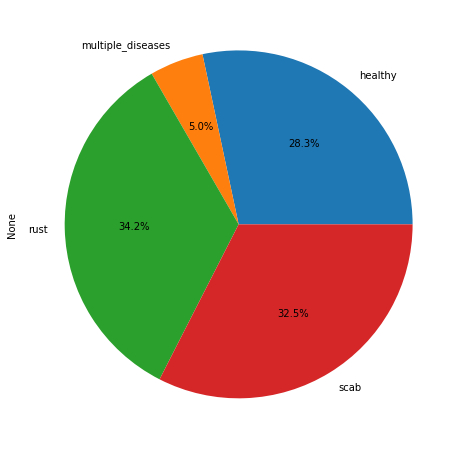

In [ ]:
ax = plt.subplot()
ax.figure.set_size_inches(8,8)
train.iloc[:,1:5].sum().plot.pie(autopct='%.1f%%',ax=ax)
plt.show()

타겟값들의 비율 차이가 커 훈련검증 데이터를 나눌 때 유의

## 이미지 출력

In [ ]:
import cv2

def show_image(img_ids, rows=2, cols=3):
    assert len(img_ids) <= rows*cols

    plt.figure(figsize=(15,8))
    grid = gridspec.GridSpec(rows,cols)

    for idx, img_id in enumerate(img_ids):
        img_path = path + 'images/' + img_id + '.jpg'
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax = plt.subplot(grid[idx])
        ax.imshow(image)

In [ ]:
num_of_imgs = 6
last_healthy_img_ids = healthy['image_id'][-num_of_imgs:]
last_multiple_diseases_img_ids = multiple_diseases['image_id'][-num_of_imgs:]
last_rust_img_ids = rust['image_id'][-num_of_imgs:]
last_scab_img_ids = scab['image_id'][-num_of_imgs:]

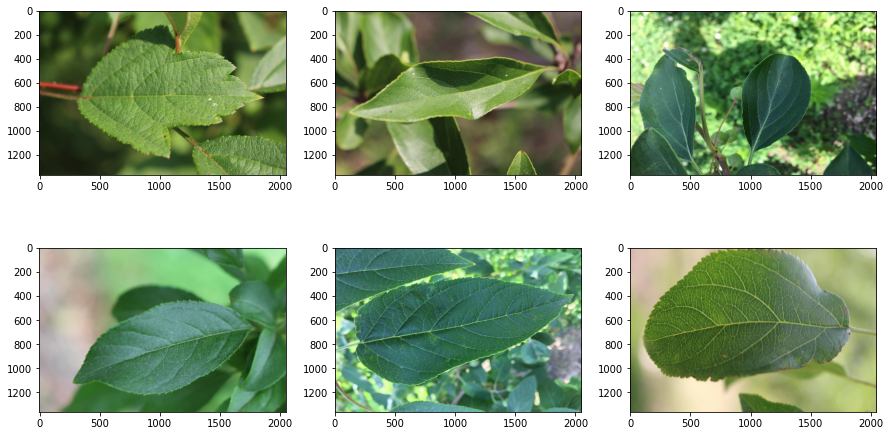

In [ ]:
show_image(last_healthy_img_ids)

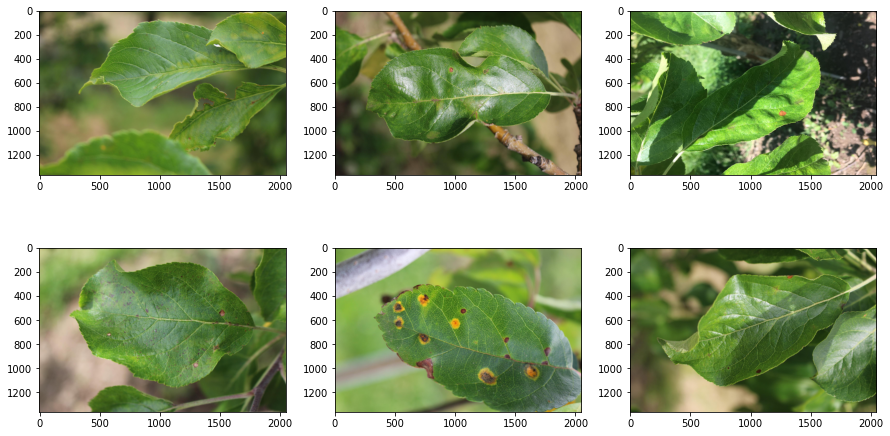

In [ ]:
show_image(last_multiple_diseases_img_ids)

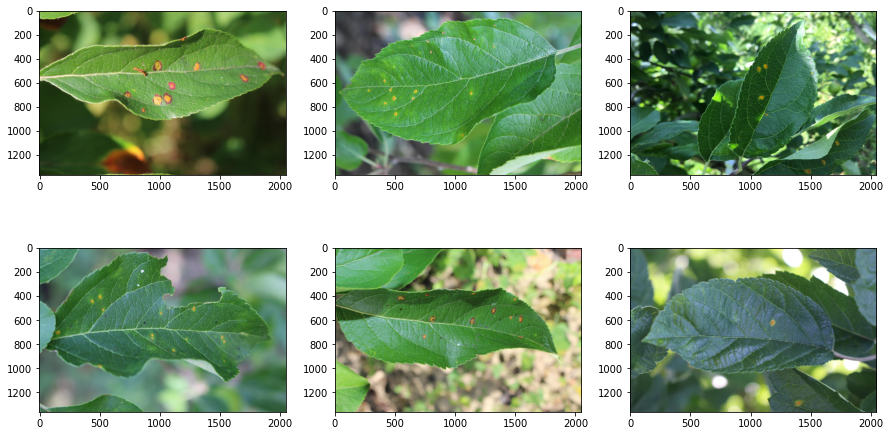

In [ ]:
show_image(last_rust_img_ids)

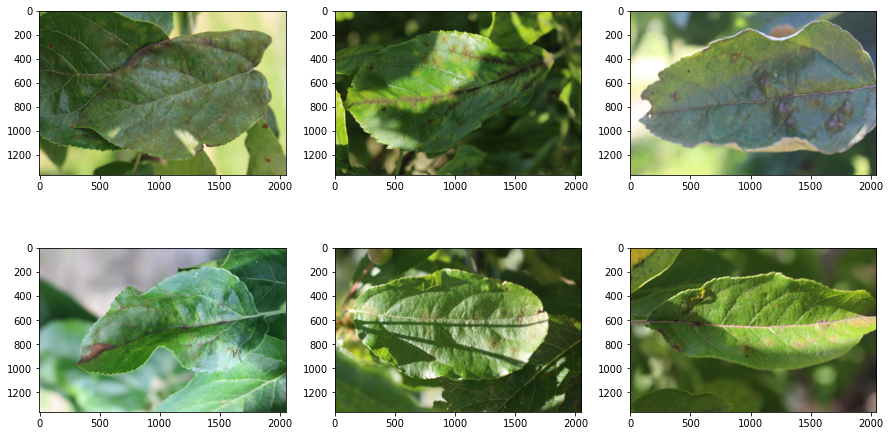

In [ ]:
show_image(last_scab_img_ids)

# 베이스 라인 모델

In [ ]:
# 연산에 이용할 장비 할당
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

device

device(type='cuda')

In [ ]:
from sklearn.model_selection import train_test_split

train = pd.read_csv(path + 'train.csv')

train, valid = train_test_split(train,
                                test_size = 0.1, # 컴퓨터 자원이 부족해 원래 데이터의 10%만 사용
                                stratify = train[['healthy','multiple_diseases','rust','scab']],
                                random_state=42)
print(train.shape, valid.shape)

(1638, 5) (183, 5)


## 데이터셋 클래스 정의

In [ ]:
import cv2 # OpenCV 라이브러리
from torch.utils.data import Dataset


class ImageDataset(Dataset):
    # 초기화 메서드(생성자)
    def __init__(self, df, img_dir='./', transform=None, is_test=False):
        super().__init__() #상속받은 Dataset의 생성자 호출
        # 전달받은 인수들 저장
        self.df = df
        self.img_dir = img_dir
        self.transform = transform
        self.is_test = is_test
    
    # 데이터셋 크기 반환 메서드
    def __len__(self):
        return len(self.df)

    # 인덱스에 해당하는 데이터 반환 메서드
    def __getitem__(self, idx):
        img_id = self.df.iloc[idx,0]                  # 이미지 ID
        img_path = path + 'images/' + img_id + '.jpg' # 이미지 파일 경로
        image = cv2.imread(img_path)                  # 이미지 파일 읽기
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)# 이미지 색상 보정
        
        if self.transform is not None:
            image = self.transform(image=image)['image']
        # 테스트 데이터면 이미지 데이터만 반환, 그렇지 않으면 타겟값도 반환
        if self.is_test:
            return image
        else:
            label = np.argmax(self.df.iloc[idx, 1:5])
            return image, label

## 이미지 변환기 정의

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

# 훈련 데이터용 변환기
transform_train = A.Compose([
    A.Resize(450,650),
    A.RandomBrightnessContrast(brightness_limit=0.2,
                               contrast_limit=0.2, p=0.3),
    A.VerticalFlip(p=0.2),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(
        shift_limit=0.1,
        scale_limit=0.2,
        rotate_limit=30, p=0.3),
    A.OneOf([A.Emboss(p=1),
             A.Sharpen(p=1),
             A.Blur(p=1)], p=0.3),
    A.PiecewiseAffine(p=0.3),
    A.Normalize(),
    ToTensorV2()
])

# 검증 및 테스트 데이터용 변환기
transform_test = A.Compose([
    A.Resize(450, 650),
    A.Normalize(),
    ToTensorV2()
])

## 데이터셋 및 데이터 로더 생성

In [ ]:
img_dir = path+'images/'

dataset_train = ImageDataset(train, img_dir=img_dir, transform=transform_train)
dataset_valid = ImageDataset(valid, img_dir=img_dir, transform=transform_test)

In [ ]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

In [ ]:
from torch.utils.data import DataLoader

batch_size = 4

loader_train = DataLoader(dataset_train, batch_size=batch_size,
                          shuffle=True, worker_init_fn=seed_worker,
                          generator=g, num_workers=2)

loader_valid = DataLoader(dataset_valid, batch_size=batch_size,
                          shuffle=True, worker_init_fn=seed_worker,
                          generator=g, num_workers=2)

## 모델 생성

In [ ]:
!pip install efficientnet-pytorch==0.7.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from efficientnet_pytorch import EfficientNet

In [ ]:
model = EfficientNet.from_pretrained('efficientnet-b7', num_classes=4)

model = model.to(device)

Loaded pretrained weights for efficientnet-b7


## 손실함수와 옵티마저 설정

In [ ]:
import torch.nn as nn

criterion = nn.CrossEntropyLoss()

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00003, weight_decay=0.0001)

# 베이스라인 모델 훈련 및 성능 검증

In [ ]:
from sklearn.metrics import roc_auc_score # ROC AUC 점수 계산 함수
from tqdm.notebook import tqdm # 진행률 표시 막대 

epochs = 5

# 총 에폭만큼 반복
for epoch in range(epochs):
    # == [ 훈련 ] ==============================================
    model.train()        # 모델을 훈련 상태로 설정 
    epoch_train_loss = 0 # 에폭별 손실값 초기화 (훈련 데이터용)
    
    # '반복 횟수'만큼 반복 
    for images, labels in tqdm(loader_train):
        # 이미지, 레이블(타깃값) 데이터 미니배치를 장비에 할당 
        images = images.to(device)
        labels = labels.to(device)
        
        # 옵티마이저 내 기울기 초기화
        optimizer.zero_grad()
        # 순전파 : 이미지 데이터를 신경망 모델의 입력값으로 사용해 출력값 계산
        outputs = model(images)
        # 손실 함수를 활용해 outputs와 labels의 손실값 계산
        loss = criterion(outputs, labels)
        # 현재 배치에서의 손실 추가 (훈련 데이터용)
        epoch_train_loss += loss.item() 
        loss.backward() # 역전파 수행
        optimizer.step() # 가중치 갱신
    # 훈련 데이터 손실값 출력
    print(f'에폭 [{epoch+1}/{epochs}] - 훈련 데이터 손실값 : {epoch_train_loss/len(loader_train):.4f}')
    
    # == [ 검증 ] ==============================================
    model.eval()          # 모델을 평가 상태로 설정 
    epoch_valid_loss = 0  # 에폭별 손실값 초기화 (검증 데이터용)
    preds_list = []       # 예측 확률값 저장용 리스트 초기화 
    true_onehot_list = [] # 실제 타깃값 저장용 리스트 초기화 
    
    with torch.no_grad(): # 기울기 계산 비활성화
        # 미니배치 단위로 검증
        for images, labels in loader_valid:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            epoch_valid_loss += loss.item()
            
            preds = torch.softmax(outputs.cpu(), dim=1).numpy() # 예측 확률값
            # 실제값 (원-핫 인코딩 형식)
            true_onehot = torch.eye(4)[labels].cpu().numpy()  
            # 예측 확률값과 실제값 저장
            preds_list.extend(preds)
            true_onehot_list.extend(true_onehot)
    # 검증 데이터 손실값 및 ROC AUC 점수 출력 
    print(f'에폭 [{epoch+1}/{epochs}] - 검증 데이터 손실값 : {epoch_valid_loss/len(loader_valid):.4f} \
    / 검증 데이터 ROC AUC : {roc_auc_score(true_onehot_list, preds_list):.4f}') 

  0%|          | 0/410 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

backward()를 호출할경우 해당 스칼라에 대한 미분값이 전파되는데 이는 매번 backward를 호출 할때마다 autograd에서 추적되고있는 모든 tensor에 대해 계속 중첩해서 들어간다는 것이다. 그래서 optimizer같은 경우 매번 zero_grad()로 미분값을 0으로 바꿔주고 있었던 것

In [ ]:
# 모델 저장
torch.save({'model' : model.state_dict(),
            'optimizer' : optimizer.state_dict(),},
           path + 'EfficientNet-B7.tar')

In [ ]:
# 모델 불러오기

pretrained_model_path = path + 'EfficientNet-B7.tar'

checkpoint = torch.load(pretrained_model_path)

model.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])

In [ ]:
del checkpoint

## 예측 및 결과 제출

In [ ]:
dataset_test = ImageDataset(test, img_dir=img_dir, 
                            transform=transform_test, is_test=True)

loader_test = DataLoader(dataset_test, batch_size=batch_size, 
                         shuffle=False, worker_init_fn=seed_worker,
                         generator=g, num_workers=2)

In [ ]:
model.eval() # 모델을 평가 상태로 설정 

preds = np.zeros((len(test), 4)) # 예측값 저장용 배열 초기화

with torch.no_grad():
    for i, images in enumerate(loader_test):
        images = images.to(device)
        outputs = model(images)
        # 타깃 예측 확률 
        preds_part = torch.softmax(outputs.cpu(), dim=1).squeeze().numpy()
        preds[i*batch_size:(i+1)*batch_size] += preds_part

In [ ]:
sub[['healthy', 'multiple_diseases', 'rust', 'scab']] = preds
sub.to_csv('sub.csv', index=False)

# 성능 개선

1. 에폭 늘리기
2. 스케줄러 추가
3. TTA(테스트 단계 데이터 증강)기법
4. 레이블 스무딩 적용

##스케줄러 추가

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from transformers import get_cosine_schedule_with_warmup

epochs = 39

# 스케줄러 생성
scheduler = get_cosine_schedule_with_warmup(optimizer,
                                            num_warmup_steps=len(loader_train)*3,
                                            num_training_steps=len(loader_train)*epochs)

스케줄러 역할   
훈련 초기에 학습률은 충분히 좋은 가중치에 도달하기 위해 크게 설정됩니다.        
시간이 지남에 따라 이러한 가중치는 작은 학습률을 활용하여 더 높은 정확도에 도달하도록 미세 조정됩니다.   
위의 코드는 weight가 epoch 0부터3까지 증가해 고점을찍고 그 후로 cosine함수를 따라 감소하도록 하는 스케줄러이다.

In [ ]:
!nvidia-smi

Wed Oct 12 04:51:41 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P0    27W /  70W |  14564MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
### 약5시간 소요

from sklearn.metrics import roc_auc_score # ROC AUC 점수 계산 함수
from tqdm.notebook import tqdm # 진행률 표시 막대 


# 총 에폭만큼 반복
for epoch in range(epochs):
    # == [ 훈련 ] ==============================================
    model.train()        # 모델을 훈련 상태로 설정 
    epoch_train_loss = 0 # 에폭별 손실값 초기화 (훈련 데이터용)
    
    # '반복 횟수'만큼 반복 
    for images, labels in tqdm(loader_train):
        # 이미지, 레이블(타깃값) 데이터 미니배치를 장비에 할당 
        images = images.to(device)
        labels = labels.to(device)
        
        # 옵티마이저 내 기울기 초기화
        optimizer.zero_grad()
        # 순전파 : 이미지 데이터를 신경망 모델의 입력값으로 사용해 출력값 계산
        outputs = model(images)
        # 손실 함수를 활용해 outputs와 labels의 손실값 계산
        loss = criterion(outputs, labels)
        # 현재 배치에서의 손실 추가 (훈련 데이터용)
        epoch_train_loss += loss.item() 
        loss.backward() # 역전파 수행
        optimizer.step() # 가중치 갱신
        scheduler.step() # 스케줄러 학습률 갱신
    # 훈련 데이터 손실값 출력
    print(f'에폭 [{epoch+1}/{epochs}] - 훈련 데이터 손실값 : {epoch_train_loss/len(loader_train):.4f}')
    
    # == [ 검증 ] ==============================================
    model.eval()          # 모델을 평가 상태로 설정 
    epoch_valid_loss = 0  # 에폭별 손실값 초기화 (검증 데이터용)
    preds_list = []       # 예측 확률값 저장용 리스트 초기화 
    true_onehot_list = [] # 실제 타깃값 저장용 리스트 초기화 
    
    with torch.no_grad(): # 기울기 계산 비활성화
        # 미니배치 단위로 검증
        for images, labels in loader_valid:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            epoch_valid_loss += loss.item()
            
            preds = torch.softmax(outputs.cpu(), dim=1).numpy() # 예측 확률값
            # 실제값 (원-핫 인코딩 형식)
            true_onehot = torch.eye(4)[labels].cpu().numpy()  
            # 예측 확률값과 실제값 저장
            preds_list.extend(preds)
            true_onehot_list.extend(true_onehot)
    # 검증 데이터 손실값 및 ROC AUC 점수 출력 
    print(f'에폭 [{epoch+1}/{epochs}] - 검증 데이터 손실값 : {epoch_valid_loss/len(loader_valid):.4f} \
    / 검증 데이터 ROC AUC : {roc_auc_score(true_onehot_list, preds_list):.4f}') 

  0%|          | 0/410 [00:00<?, ?it/s]

에폭 [1/39] - 훈련 데이터 손실값 : 1.3347
에폭 [1/39] - 검증 데이터 손실값 : 1.1553     / 검증 데이터 ROC AUC : 0.8733


  0%|          | 0/410 [00:00<?, ?it/s]

에폭 [2/39] - 훈련 데이터 손실값 : 0.8218
에폭 [2/39] - 검증 데이터 손실값 : 0.3171     / 검증 데이터 ROC AUC : 0.9747


  0%|          | 0/410 [00:00<?, ?it/s]

에폭 [3/39] - 훈련 데이터 손실값 : 0.4688
에폭 [3/39] - 검증 데이터 손실값 : 0.1916     / 검증 데이터 ROC AUC : 0.9933


  0%|          | 0/410 [00:00<?, ?it/s]

에폭 [4/39] - 훈련 데이터 손실값 : 0.3760
에폭 [4/39] - 검증 데이터 손실값 : 0.1702     / 검증 데이터 ROC AUC : 0.9831


  0%|          | 0/410 [00:00<?, ?it/s]

에폭 [5/39] - 훈련 데이터 손실값 : 0.3117
에폭 [5/39] - 검증 데이터 손실값 : 0.1873     / 검증 데이터 ROC AUC : 0.9733


  0%|          | 0/410 [00:00<?, ?it/s]

에폭 [6/39] - 훈련 데이터 손실값 : 0.2625
에폭 [6/39] - 검증 데이터 손실값 : 0.1685     / 검증 데이터 ROC AUC : 0.9843


  0%|          | 0/410 [00:00<?, ?it/s]

에폭 [7/39] - 훈련 데이터 손실값 : 0.1647
에폭 [7/39] - 검증 데이터 손실값 : 0.1697     / 검증 데이터 ROC AUC : 0.9778


  0%|          | 0/410 [00:00<?, ?it/s]

에폭 [8/39] - 훈련 데이터 손실값 : 0.1773
에폭 [8/39] - 검증 데이터 손실값 : 0.1745     / 검증 데이터 ROC AUC : 0.9691


  0%|          | 0/410 [00:00<?, ?it/s]

에폭 [9/39] - 훈련 데이터 손실값 : 0.1185
에폭 [9/39] - 검증 데이터 손실값 : 0.1918     / 검증 데이터 ROC AUC : 0.9564


  0%|          | 0/410 [00:00<?, ?it/s]

에폭 [10/39] - 훈련 데이터 손실값 : 0.1047
에폭 [10/39] - 검증 데이터 손실값 : 0.1947     / 검증 데이터 ROC AUC : 0.9671


  0%|          | 0/410 [00:00<?, ?it/s]

에폭 [11/39] - 훈련 데이터 손실값 : 0.0945
에폭 [11/39] - 검증 데이터 손실값 : 0.1458     / 검증 데이터 ROC AUC : 0.9783


  0%|          | 0/410 [00:00<?, ?it/s]

에폭 [12/39] - 훈련 데이터 손실값 : 0.0660
에폭 [12/39] - 검증 데이터 손실값 : 0.1718     / 검증 데이터 ROC AUC : 0.9730


  0%|          | 0/410 [00:00<?, ?it/s]

에폭 [13/39] - 훈련 데이터 손실값 : 0.0603
에폭 [13/39] - 검증 데이터 손실값 : 0.1759     / 검증 데이터 ROC AUC : 0.9706


  0%|          | 0/410 [00:00<?, ?it/s]

에폭 [14/39] - 훈련 데이터 손실값 : 0.0505
에폭 [14/39] - 검증 데이터 손실값 : 0.1699     / 검증 데이터 ROC AUC : 0.9795


  0%|          | 0/410 [00:00<?, ?it/s]

에폭 [15/39] - 훈련 데이터 손실값 : 0.0389
에폭 [15/39] - 검증 데이터 손실값 : 0.2030     / 검증 데이터 ROC AUC : 0.9687


  0%|          | 0/410 [00:00<?, ?it/s]

에폭 [16/39] - 훈련 데이터 손실값 : 0.0427
에폭 [16/39] - 검증 데이터 손실값 : 0.2007     / 검증 데이터 ROC AUC : 0.9619


  0%|          | 0/410 [00:00<?, ?it/s]

에폭 [17/39] - 훈련 데이터 손실값 : 0.0303
에폭 [17/39] - 검증 데이터 손실값 : 0.2222     / 검증 데이터 ROC AUC : 0.9669


  0%|          | 0/410 [00:00<?, ?it/s]

에폭 [18/39] - 훈련 데이터 손실값 : 0.0291
에폭 [18/39] - 검증 데이터 손실값 : 0.2523     / 검증 데이터 ROC AUC : 0.9634


  0%|          | 0/410 [00:00<?, ?it/s]

에폭 [19/39] - 훈련 데이터 손실값 : 0.0297
에폭 [19/39] - 검증 데이터 손실값 : 0.2273     / 검증 데이터 ROC AUC : 0.9641


  0%|          | 0/410 [00:00<?, ?it/s]

에폭 [20/39] - 훈련 데이터 손실값 : 0.0311
에폭 [20/39] - 검증 데이터 손실값 : 0.2190     / 검증 데이터 ROC AUC : 0.9755


  0%|          | 0/410 [00:00<?, ?it/s]

에폭 [21/39] - 훈련 데이터 손실값 : 0.0233
에폭 [21/39] - 검증 데이터 손실값 : 0.1977     / 검증 데이터 ROC AUC : 0.9772


  0%|          | 0/410 [00:00<?, ?it/s]

에폭 [22/39] - 훈련 데이터 손실값 : 0.0231
에폭 [22/39] - 검증 데이터 손실값 : 0.2446     / 검증 데이터 ROC AUC : 0.9761


  0%|          | 0/410 [00:00<?, ?it/s]

에폭 [23/39] - 훈련 데이터 손실값 : 0.0282
에폭 [23/39] - 검증 데이터 손실값 : 0.2091     / 검증 데이터 ROC AUC : 0.9765


  0%|          | 0/410 [00:00<?, ?it/s]

에폭 [24/39] - 훈련 데이터 손실값 : 0.0191
에폭 [24/39] - 검증 데이터 손실값 : 0.1881     / 검증 데이터 ROC AUC : 0.9838


  0%|          | 0/410 [00:00<?, ?it/s]

에폭 [25/39] - 훈련 데이터 손실값 : 0.0172
에폭 [25/39] - 검증 데이터 손실값 : 0.2039     / 검증 데이터 ROC AUC : 0.9802


  0%|          | 0/410 [00:00<?, ?it/s]

에폭 [26/39] - 훈련 데이터 손실값 : 0.0130
에폭 [26/39] - 검증 데이터 손실값 : 0.2004     / 검증 데이터 ROC AUC : 0.9740


  0%|          | 0/410 [00:00<?, ?it/s]

에폭 [27/39] - 훈련 데이터 손실값 : 0.0131
에폭 [27/39] - 검증 데이터 손실값 : 0.1972     / 검증 데이터 ROC AUC : 0.9806


  0%|          | 0/410 [00:00<?, ?it/s]

에폭 [28/39] - 훈련 데이터 손실값 : 0.0104
에폭 [28/39] - 검증 데이터 손실값 : 0.2056     / 검증 데이터 ROC AUC : 0.9776


  0%|          | 0/410 [00:00<?, ?it/s]

에폭 [29/39] - 훈련 데이터 손실값 : 0.0122
에폭 [29/39] - 검증 데이터 손실값 : 0.2067     / 검증 데이터 ROC AUC : 0.9766


  0%|          | 0/410 [00:00<?, ?it/s]

에폭 [30/39] - 훈련 데이터 손실값 : 0.0109
에폭 [30/39] - 검증 데이터 손실값 : 0.1918     / 검증 데이터 ROC AUC : 0.9829


  0%|          | 0/410 [00:00<?, ?it/s]

에폭 [31/39] - 훈련 데이터 손실값 : 0.0066
에폭 [31/39] - 검증 데이터 손실값 : 0.2101     / 검증 데이터 ROC AUC : 0.9775


  0%|          | 0/410 [00:00<?, ?it/s]

에폭 [32/39] - 훈련 데이터 손실값 : 0.0059
에폭 [32/39] - 검증 데이터 손실값 : 0.2094     / 검증 데이터 ROC AUC : 0.9771


  0%|          | 0/410 [00:00<?, ?it/s]

에폭 [33/39] - 훈련 데이터 손실값 : 0.0120
에폭 [33/39] - 검증 데이터 손실값 : 0.1969     / 검증 데이터 ROC AUC : 0.9778


  0%|          | 0/410 [00:00<?, ?it/s]

에폭 [34/39] - 훈련 데이터 손실값 : 0.0048
에폭 [34/39] - 검증 데이터 손실값 : 0.1981     / 검증 데이터 ROC AUC : 0.9760


  0%|          | 0/410 [00:00<?, ?it/s]

에폭 [35/39] - 훈련 데이터 손실값 : 0.0070
에폭 [35/39] - 검증 데이터 손실값 : 0.2006     / 검증 데이터 ROC AUC : 0.9766


  0%|          | 0/410 [00:00<?, ?it/s]

에폭 [36/39] - 훈련 데이터 손실값 : 0.0087
에폭 [36/39] - 검증 데이터 손실값 : 0.2026     / 검증 데이터 ROC AUC : 0.9765


  0%|          | 0/410 [00:00<?, ?it/s]

에폭 [37/39] - 훈련 데이터 손실값 : 0.0102
에폭 [37/39] - 검증 데이터 손실값 : 0.2048     / 검증 데이터 ROC AUC : 0.9751


  0%|          | 0/410 [00:00<?, ?it/s]

에폭 [38/39] - 훈련 데이터 손실값 : 0.0184
에폭 [38/39] - 검증 데이터 손실값 : 0.2027     / 검증 데이터 ROC AUC : 0.9765


  0%|          | 0/410 [00:00<?, ?it/s]

에폭 [39/39] - 훈련 데이터 손실값 : 0.0086
에폭 [39/39] - 검증 데이터 손실값 : 0.2086     / 검증 데이터 ROC AUC : 0.9761


In [ ]:
# 모델 저장
torch.save({'model' : model.state_dict(),
            'optimizer' : optimizer.state_dict(),},
           path + 'EfficientNet-B7-01.tar')

In [ ]:
# 모델 불러오기

pretrained_model_path = path + 'EfficientNet-B7-01.tar'

checkpoint = torch.load(pretrained_model_path)

model.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])

## TTA 테스트 단계 데이터 증강

In [ ]:
dataset_TTA = ImageDataset(test, img_dir=img_dir, 
                            transform=transform_train, is_test=True)

loader_TTA = DataLoader(dataset_TTA, batch_size=batch_size, 
                         shuffle=False, worker_init_fn=seed_worker,
                         generator=g, num_workers=2)

원본용 데이터셋을 만들 때는 변환기로 transform_test를 전달했다.   
TTA용에서는 transfrom_train을 전달하여 훈련데이터처럼 여러 변환을 수행하도록 했다.

In [ ]:
num_TTA = 7

model.eval() # 모델을 평가 상태로 설정 

preds_TTA = np.zeros((len(test), 4)) # 예측값 저장용 배열 초기화

for i in range(num_TTA):
    with torch.no_grad():
        for i, images in enumerate(loader_test):
            images = images.to(device)
            outputs = model(images)
            # 타깃 예측 확률 
            preds_part = torch.softmax(outputs.cpu(), dim=1).squeeze().numpy()
            preds_TTA[i*batch_size:(i+1)*batch_size] += preds_part

In [ ]:
preds_TTA /= num_TTA

sub_tta = sub.copy()
sub_tta[['healthy', 'multiple_diseases', 'rust', 'scab']] = preds_TTA

## 레이블 스무딩

In [ ]:
def apply_label_smoothing(df, target, alpha, threshold):
    df_target = df['target'].copy()
    k = len(target)

    for idx, row in df_target.iterrows():
        if (row > threshold).any():
            row = (1 - alpha) * row + alpha/k
            df_target.iloc[idx] = row
    return df_target

In [ ]:
alpha = 0.001
threshold = 0.999

sub_tta_ls = sub_tta.copy()

target = ['healthy', 'multiple_diseases', 'rust', 'scab']

sub_tta_ls['target'] = apply_label_smoothing(sub_tta, target, alpha, threshold)

sub_tta_ls.to_csv('sub_tta_ls.csv', index=False)